In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [10]:
# True parameter values
mu=0
sigma=1

def qdf(size):
    # draws a random sample with size=size from the true "uknown distribution"
    return np.random.normal(loc=mu, scale=sigma, size=size)


n_factors = np.array([10, 50, 100])


# Predictor variable
X1 = np.random.randn(n)
X2 = np.random.randn(n) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=n) * sigma

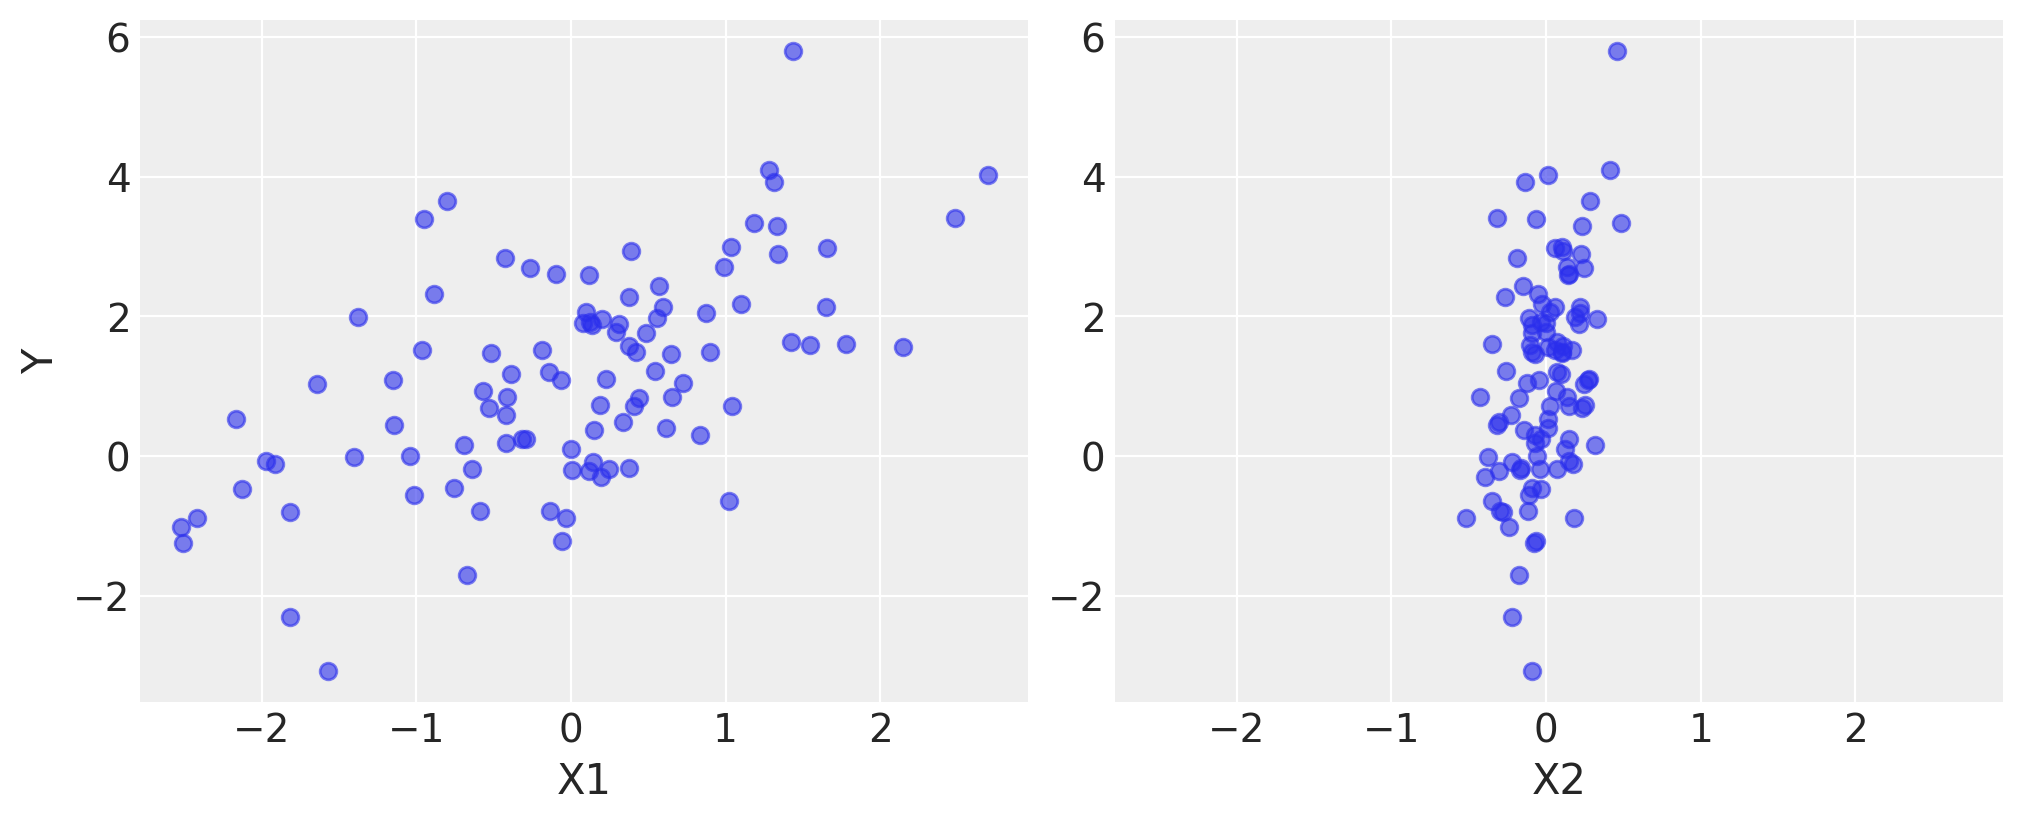

In [12]:
# data = pd.DataFrame({"x1":X1, "x2":X2, "t": np.arange(100)})
# plt.scatter(data.x1, data.x2)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [13]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.22.0


In [14]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [15]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


/Users/ashrafahmed/workspace/singular-learning-theory/code/python/.venv/lib/python3.12/site-packages/rich/live.py:2
31: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [22]:
idata.posterior["alpha"].sel(draw=slice(0,4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.19287349, 1.14817031, 1.14704851, 1.16578026, 1.15680711],
       [0.96557385, 1.31416317, 1.03866078, 1.29393412, 1.44664074],
       [1.16668323, 0.99467795, 1.07264163, 1.14008588, 1.06163429],
       [1.09961103, 1.17326363, 1.09379898, 1.08560011, 1.15403121]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

In [23]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


/Users/ashrafahmed/workspace/singular-learning-theory/code/python/.venv/lib/python3.12/site-packages/rich/live.py:2
31: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [39]:
slice_idata.posterior["alpha"][1].shape

(5000,)

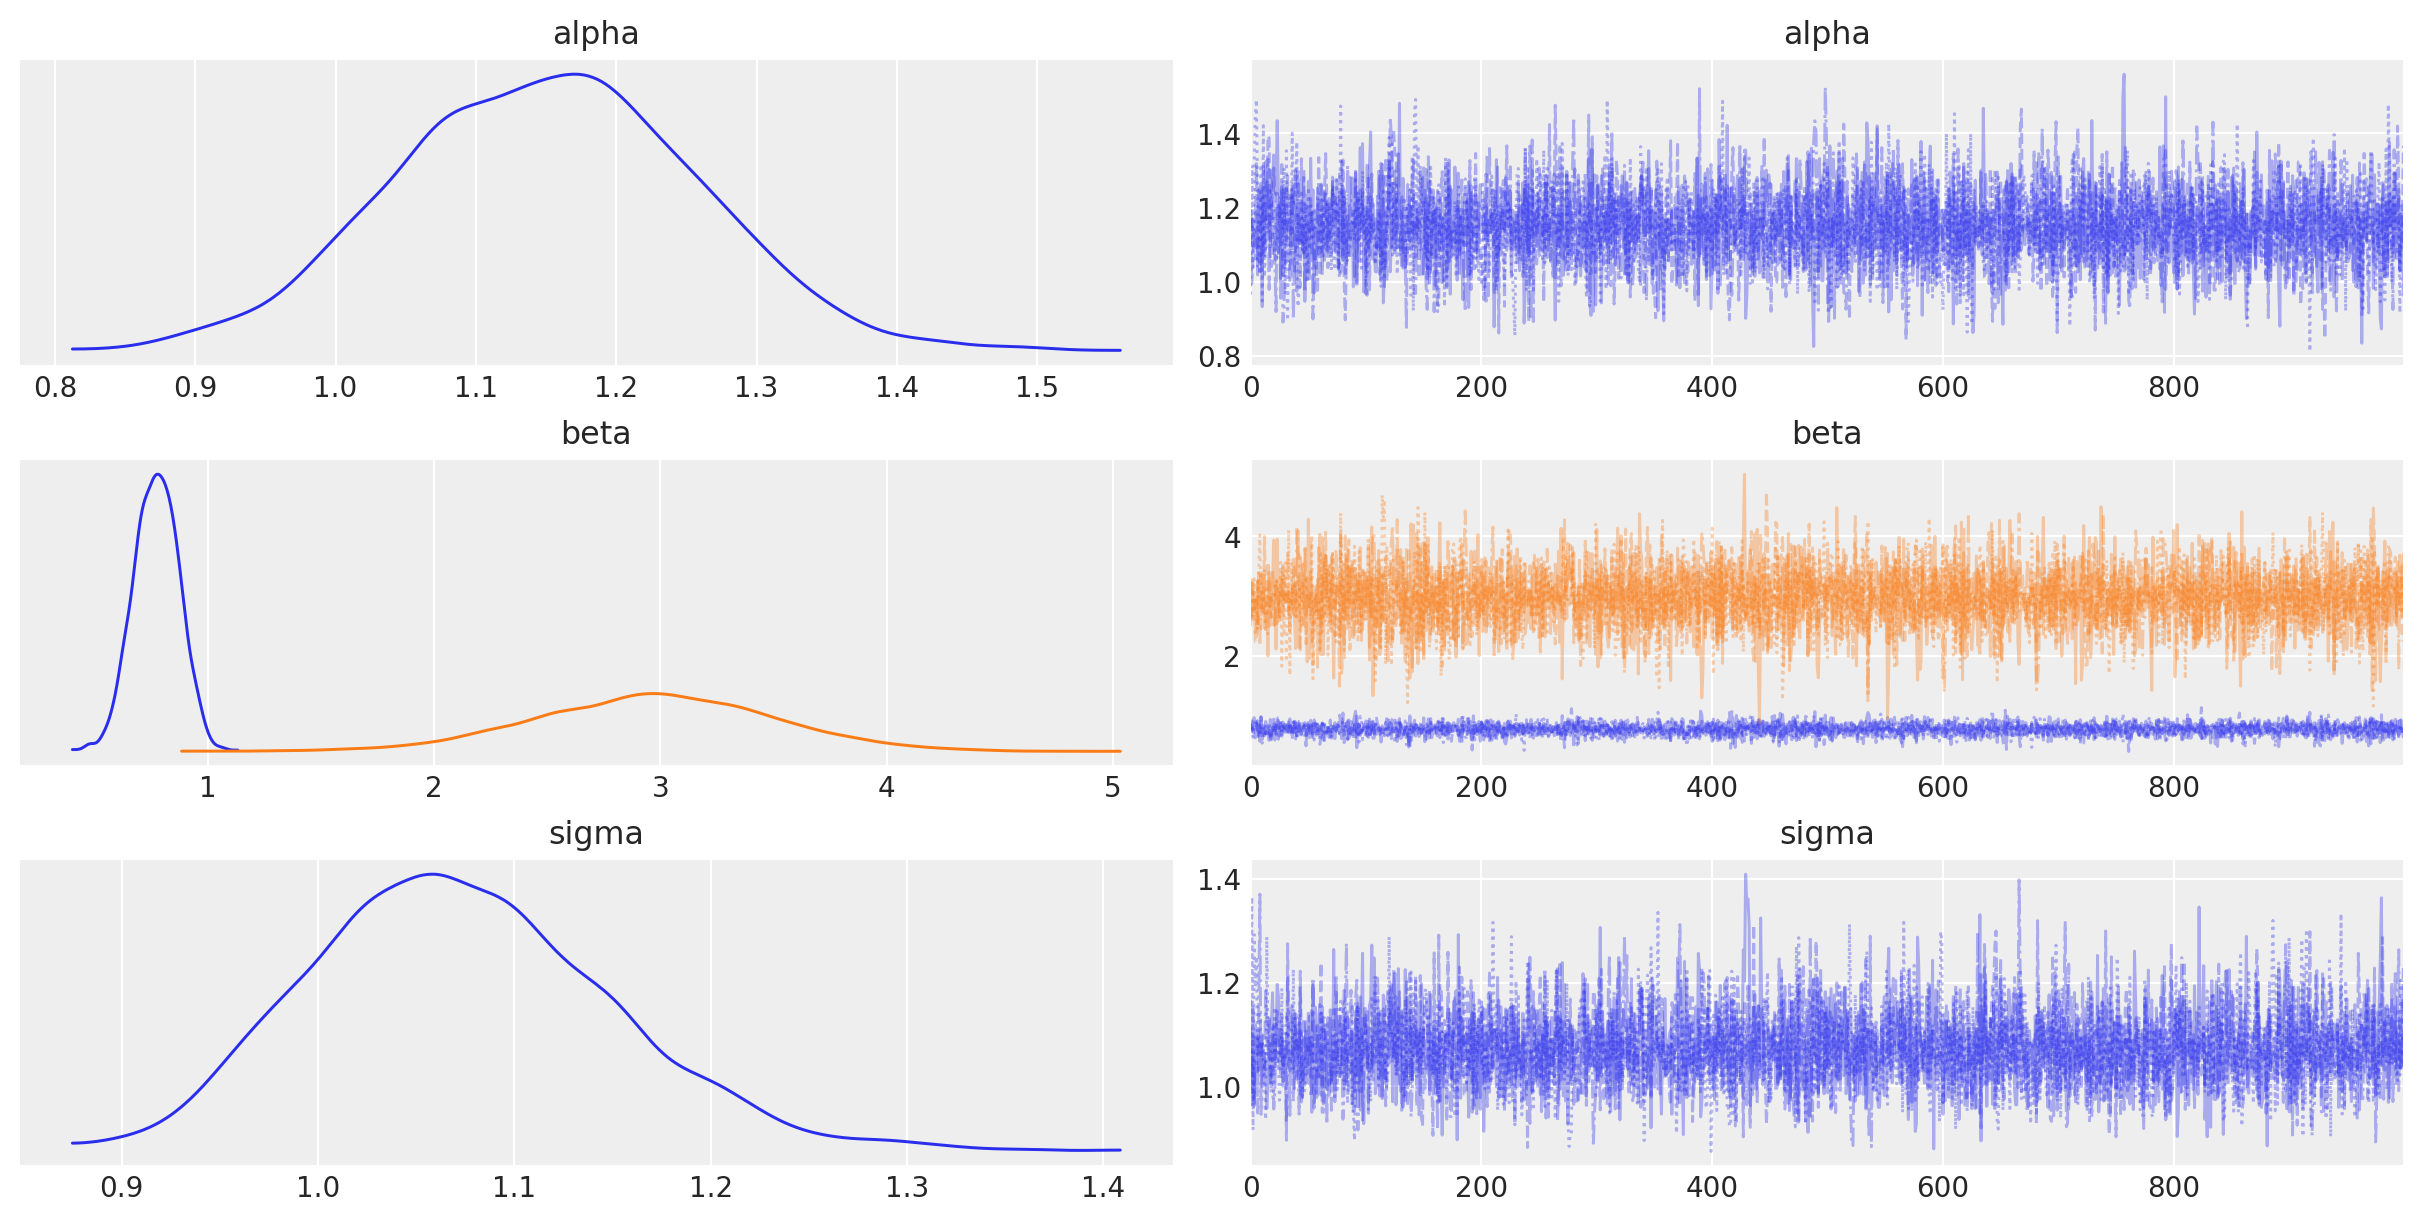

In [40]:
az.plot_trace(idata, combined=True);

In [41]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.11,0.96,1.36,0.00,0.00,5485.95,3022.00,1.0
beta[0],0.77,0.10,0.58,0.95,0.00,0.00,6280.50,3438.30,1.0
beta[1],2.97,0.53,1.96,3.92,0.01,0.01,5626.92,3067.17,1.0
sigma,1.07,0.08,0.93,1.21,0.00,0.00,4916.36,3033.15,1.0


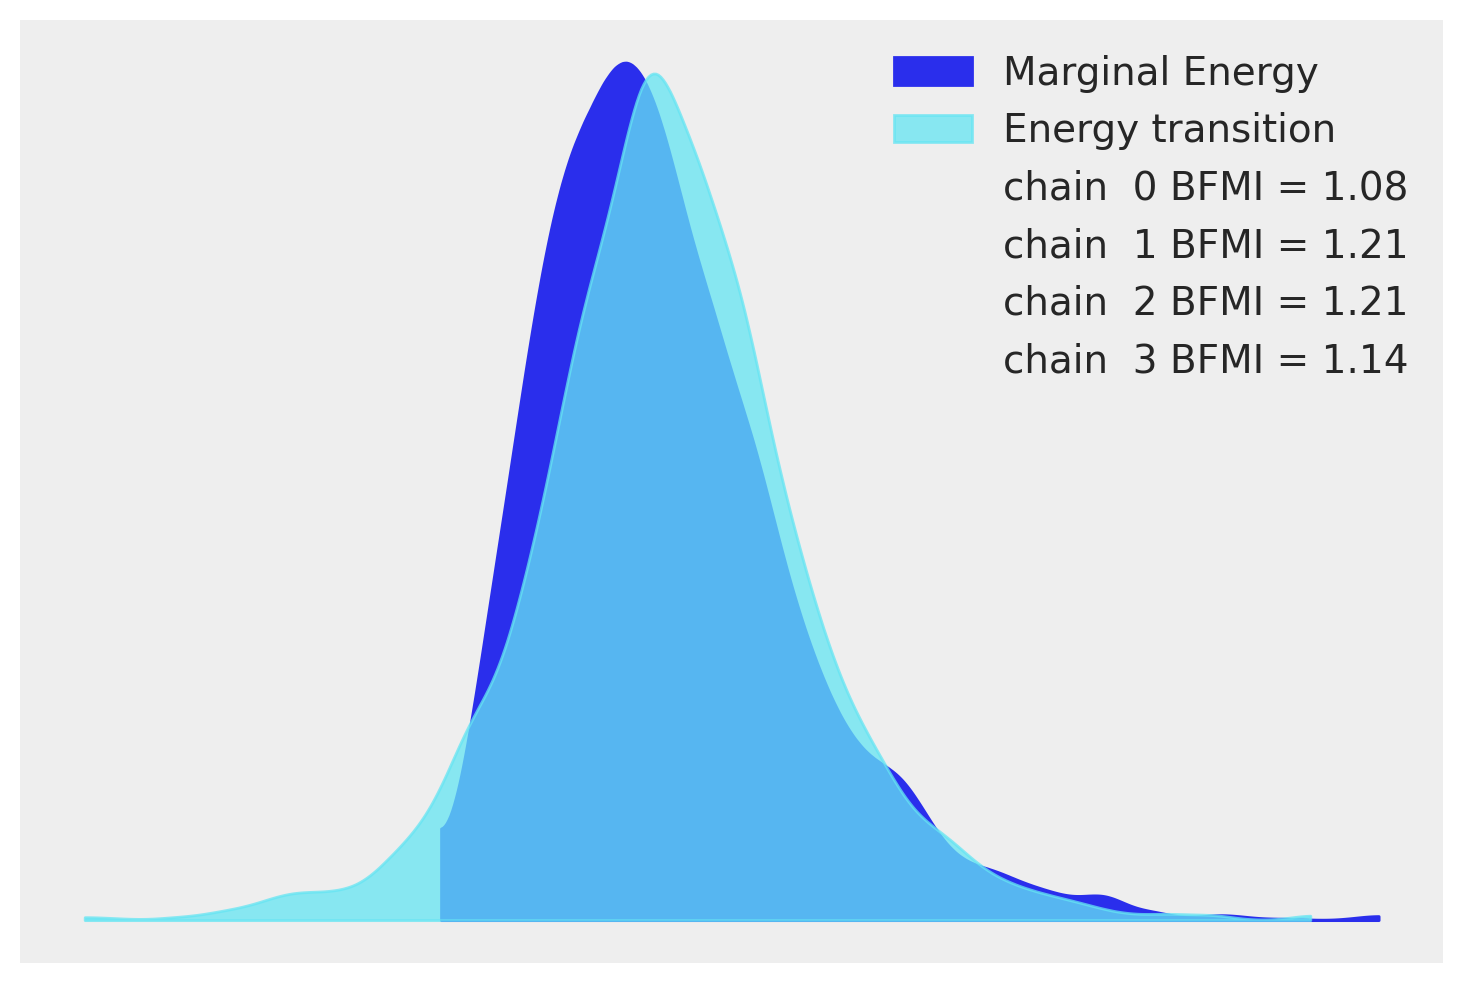

In [42]:
az.plot_energy(idata);

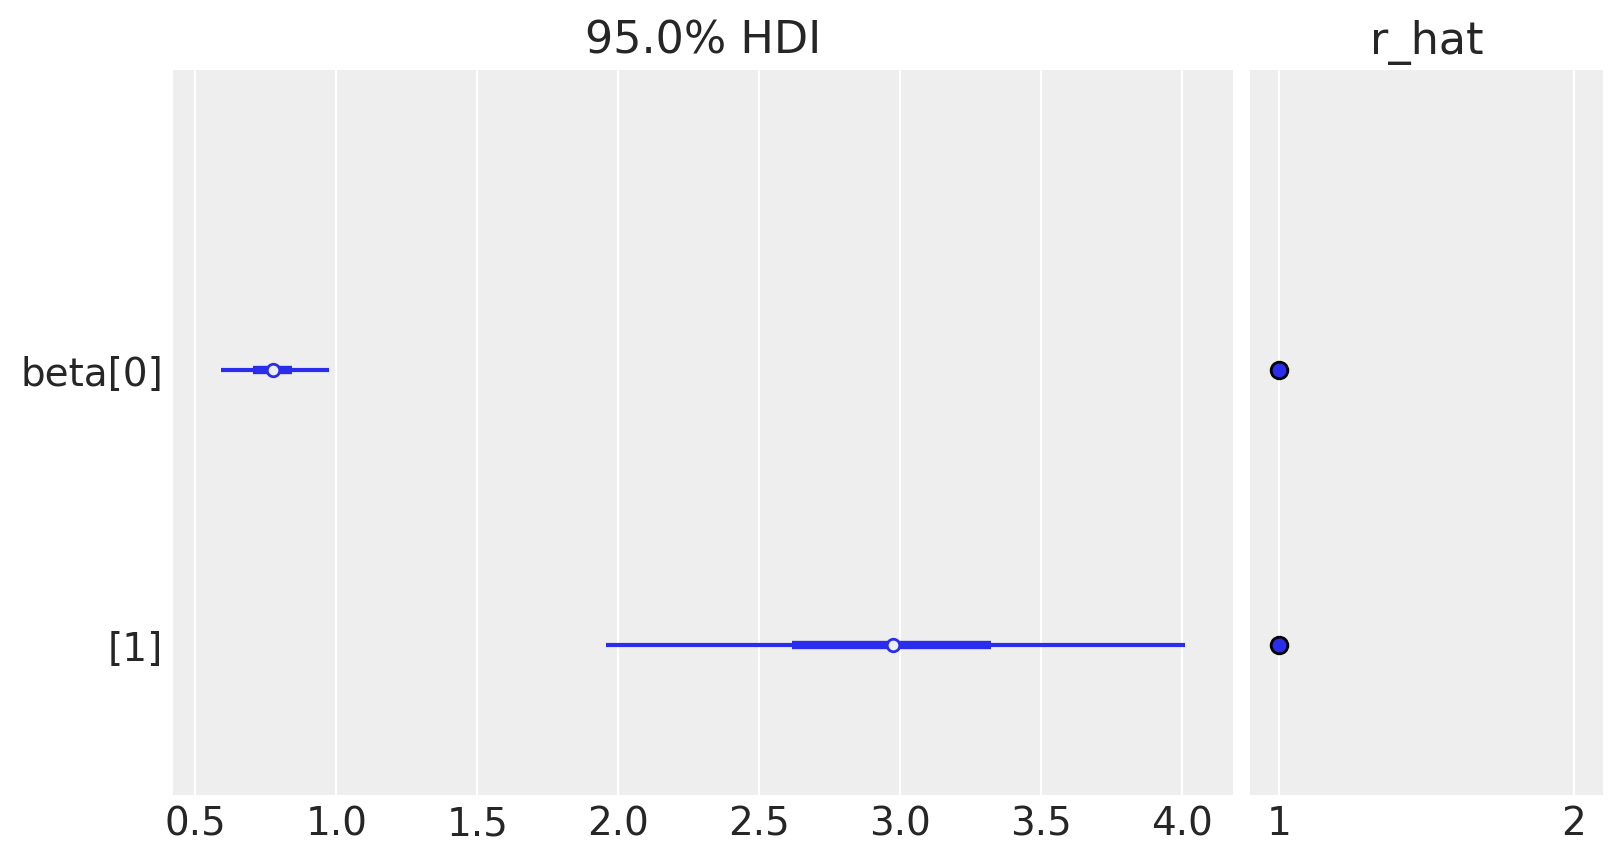

In [44]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);